In [1]:
import pandas as pd
import os
import torch
import sklearn as sl
import numpy as np
from torch import nn
import torch.nn.functional as F

## Data Download

In [2]:
from functions import downloadData

path = (r'C:\Users\Luke\Downloads\reviews_Electronics_5.json')

data = downloadData(path = path, n = 100000)

In [ ]:
data.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


**Data Transform**

In [ ]:
from functions import advTransformData
from functions import transformData
from functions import saveCSV

#transformed_data = pd.read_csv(r"C:\Users\Luke\MyRepo\ReviewGPT\transformed_data.csv")
transformed_data = pd.read_csv(r'C:\Users\Luke\MyRepo\ReviewGPT\Results\less_transformed.csv')

In [ ]:
transformed_data.drop('Unnamed: 0', axis=1, inplace = True)
transformed_data

,overall,helpful_ratio,overall_positive,excellent,good,great,impressive,satisfactory,outstanding,fantastic,...,troublesome,detestable,abominable,repugnant,lamentable,revolting,displeasing,dismaying,termination,apprehensive
0,4,0.00,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0.93,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.82,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4,0.96,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,3,0.50,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99997,4,0.00,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99998,3,0.40,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Modelling

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [ ]:
from functions import ScoreNeuralNetwork
from functions import ScoreNeuralNetworkOrdinal
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from functions import ordinalEncoder

#create class weights
weights = (transformed_data['overall'].value_counts().sort_index()[4]/transformed_data['overall'].value_counts().sort_index())
weights = torch.tensor(weights.values, dtype = torch.float32).to(device)

#Create data frames for x and y. Here we convert y to np array
response_var = transformed_data['overall']
#response_var = ordinalEncoder(response_var)
response_var = pd.get_dummies(response_var)

predictor_var = transformed_data.drop(['overall_positive', 'overall'], axis = 1)

#Create test and train datasets
X_train, X_test, Y_train, Y_test = train_test_split(predictor_var, response_var, test_size=0.1, random_state=42, stratify=response_var)


#Create tensors
response_var_t = torch.tensor(Y_train.values, dtype = torch.float32).to(device)
predictor_var_t = torch.tensor(X_train.values, dtype = torch.float32).to(device)

#Create model
n_columns = len(transformed_data.columns)-2

model = ScoreNeuralNetwork(n_input = n_columns, n_hidden_layer = n_columns, n_output = 5, learning_rate = 0.0075, weights = weights).to(device)
print(model)

ScoreNeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=251, out_features=251, bias=False)
    (1): ReLU()
    (2): Linear(in_features=251, out_features=5, bias=False)
    (3): Sigmoid()
  )
  (loss_function): CrossEntropyLoss()
)


250 iterations complete, current test accuracy: 0.20, curr entropy: 4.850009918212891
250 iterations complete, current test accuracy: 0.21, curr entropy: 4.848152160644531
250 iterations complete, current test accuracy: 0.24, curr entropy: 4.8462347984313965
250 iterations complete, current test accuracy: 0.25, curr entropy: 4.844222068786621
250 iterations complete, current test accuracy: 0.26, curr entropy: 4.842079162597656
250 iterations complete, current test accuracy: 0.27, curr entropy: 4.83976411819458
250 iterations complete, current test accuracy: 0.28, curr entropy: 4.8372368812561035
250 iterations complete, current test accuracy: 0.29, curr entropy: 4.834453105926514
250 iterations complete, current test accuracy: 0.30, curr entropy: 4.8313703536987305
250 iterations complete, current test accuracy: 0.31, curr entropy: 4.827953338623047
250 iterations complete, current test accuracy: 0.32, curr entropy: 4.824163913726807
250 iterations complete, current test accuracy: 0.33

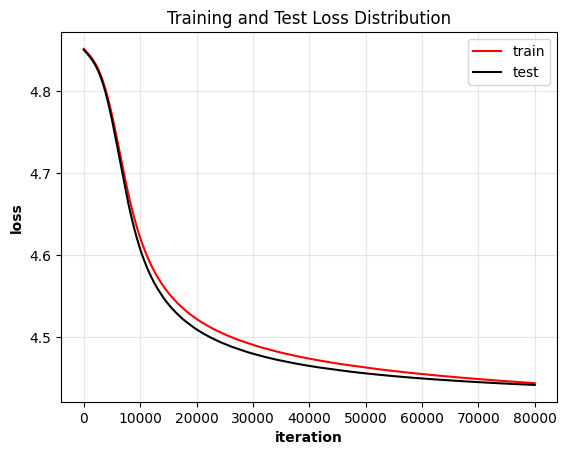

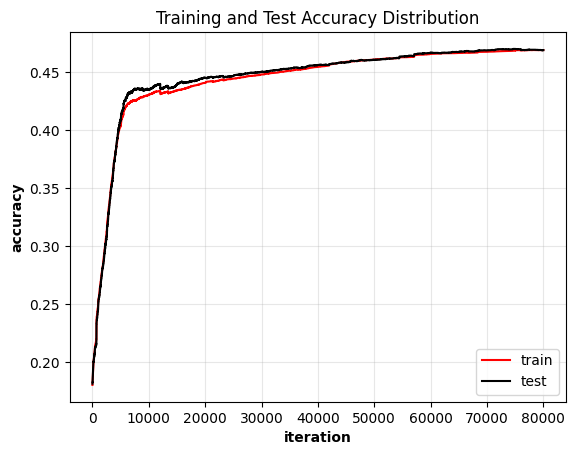

best accuracy achieved at iteration 74606 with accuracy 0.47


In [ ]:
#Convert test data to tensors
Y_test_t = torch.tensor(Y_test.values, dtype = torch.float32).to(device)
X_test_t = torch.tensor(X_test.values, dtype = torch.float32).to(device)

model.train(x_train = predictor_var_t, y_train = response_var_t, batch_size=90000, x_test = X_test_t, y_test = Y_test_t)

## Model Diagnostics ##

In [ ]:
from utils import accuracy
from functions import inverseDummies

X_test_t = torch.tensor(X_test.values, dtype = torch.float32).to(device)

predictions_prob = model.model(X_test_t).detach().cpu().numpy()
#Turn probability into prediction
max_indices = np.argmax(predictions_prob, axis=1)

#Y_test_unenc = ordinalEncoder(Y_test, inverse = True)
Y_test_unec = inverseDummies(Y_test)

accuracy(Y_test_unec, max_indices)

Accuracy: 0.4699
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.62      0.30       653
           1       0.14      0.24      0.17       479
           2       0.16      0.11      0.13       798
           3       0.31      0.34      0.32      2041
           4       0.78      0.57      0.66      6029

    accuracy                           0.47     10000
   macro avg       0.32      0.37      0.32     10000
weighted avg       0.57      0.47      0.50     10000

